### Example, full version steel data, version 3 + weather data

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

# replace this with your own file path in your own file system
# replace this with your own file path in your own file system
df = pd.read_csv('../data/sulatto_fulldata2025_version2.csv', delimiter=";", index_col=None)

# load the weather data that matches partially with our steel data (originally FMI)
df_weather = pd.read_csv('../data/tornio_weather.csv')

C:\Users\Niko Vuokila\AppData\Local\Temp\ipykernel_4988\4142740588.py:9: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/sulatto_fulldata2025_version2.csv', delimiter=";", index_col=None)


In [48]:
df.describe()

,Weight,Width,Seg No,CCM.TD. Heat counter Value,CCM.TD. Temperature liquidus Value,CCM.TD. Temperature liquidus Dynaphase Value,CCM.TD. Superheat Value,CCM.TD. Temperature tundish Value,CCM.SEN. Immersion depth Value,CCM.MD. Mold width Value,CCM.SLAB. Slab counter heat Value,CCM.SLAB. Slab counter sequence Value,HeatNo_in_Cast,CastNo
count,677815.000000,677815.000000,677815.000000,677299.000000,677299.0,677299.000000,677299.000000,677299.000000,677299.000000,677299.000000,674264.000000,674496.000000,677815.000000,671826.000000
mean,23864.551870,1388.799020,55.634902,4.230857,1455.0,1458.794001,37.868677,1492.868677,180.253312,1388.580491,3.602762,23.412446,3853.831222,175.767377
std,3581.849791,151.115179,32.787337,2.264734,0.0,1.703725,8.310765,8.310765,14.401174,151.113934,1.830274,14.367370,2041.101896,42.724486
min,6700.000000,1034.000000,1.000000,1.000000,1455.0,1452.000000,-3.000000,1452.000000,0.000000,1034.000000,1.000000,1.000000,315.000000,100.000000
25%,23218.000000,1284.000000,28.000000,2.000000,1455.0,1458.000000,34.000000,1489.000000,170.000000,1284.000000,2.000000,11.000000,2079.000000,140.000000
50%,23280.000000,1284.000000,55.000000,4.000000,1455.0,1459.000000,38.000000,1493.000000,182.000000,1284.000000,4.000000,22.000000,3878.000000,178.000000
75%,25795.000000,1543.000000,83.000000,6.000000,1455.0,1460.000000,42.000000,1497.000000,190.000000,1543.000000,5.000000,35.000000,5607.000000,212.000000
max,123605.000000,1620.000000,511.000000,10.000000,1455.0,1461.000000,145.000000,1600.000000,204.000000,1620.000000,9.000000,64.000000,7385.000000,248.000000


### Merging: Combine Steel data with weather data

#### Before we merge these datasets, we have to match their style of datetimes, which will be then used as the basis of merging (connecting point)

In [49]:
# Step 1: remove the seconds from the steel data
# Steel data: 2023-02-20 20:56:00
# Weather data: year, month, day separately + time : 00:30 (ten minute intervals)

# remove the the seconds (2 numbers + ":")
df['End time'] = df['End time'].str[:-3]

# seems to work! steel data datetime is now e.g. 2023-02-06 01:05

In [50]:
df_weather.columns

Index(['Observation station', 'Year', 'Month', 'Day', 'Time [Local time]',
       'Air temperature mean [°C]', 'Dew-point temperature mean [°C]',
       'Cloud cover [1/8]', 'Air pressure mean [hPa]',
       'Relative humidity mean [%]', 'Precipitation amount mean [mm]',
       'Weather description', 'Horizontal visibility mean [m]'],
      dtype='object')

In [51]:
# Step 2: combine all weather time information into a new variable => End time (same as in steel data)
df_weather['End time'] = df_weather['Year'].astype(str) + "-" + \
                         df_weather['Month'].astype(str).str.zfill(2) + "-" + \
                         df_weather['Day'].astype(str).str.zfill(2) + " " + \
                         df_weather['Time [Local time]'].astype(str)

In [52]:
# logic of the astype(str).str above:
# df_weather['Month'].astype(str) => convert this column into string
# df_weather['Month'].str.zfill(2) => use Python's string -functions (str) -> zfill

In [53]:
# for comparison, steel data has the time: 2023-02-06 01:05
df_weather.head(3)['End time']

0    2023-01-01 00:00
1    2023-01-01 00:10
2    2023-01-01 00:20
Name: End time, dtype: object

In [54]:
# Final step before merging: ROUND THE STEEL DATA minutes into the nearest tens of minutes
# basically we can make a function for pandas to fix this
# the idea: get the minutes from the time
# => round the minutes to nearest 10
# => convert minutes back to string => combine with the original time
def fix_date(row):
    date = row['End time']

    # extract te minutes only from the date
    minutes = int(date[-2:])

    # round the minutes to the nearest ten (by using negative round decimal amount)
    minutes = round(minutes, -1)

    # rebuild the date string
    # date[0:-2] => everything else except the minutes
    result = date[0:-2] + str(minutes).zfill(2)
    return result

# apply the function and check results
df['End time'] = df.apply(fix_date, axis=1)

#### Now we can proceed with merging the steel data and the weather


In [55]:
# merge data (very similar to SQL joins)
df = df.merge(df_weather, left_on="End time", right_on="End time", how="left")

In [56]:
df.columns

Index(['Material Type', 'End time', 'Route', 'Weight', 'Length', 'Thickness',
       'Width', 'Grade', 'Quality Status', 'Seg No', 'Seg from', 'Seg to',
       'CCM.TD. Heat counter Value', 'CCM.TD. Temperature liquidus Value',
       'CCM.TD. Temperature liquidus Dynaphase Value',
       'CCM.TD. TD internals type Value', 'CCM.TD. Slag powder Value',
       'CCM.TD. Stopper Type Value', 'CCM.TD. Steel weight in tundish Value',
       'CCM.TD. Tundish inflow Value', 'CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Stopper pos chg max segment Value',
       'CCM.TD. Stopper position chg 10 s Value',
       'CCM.TD. Stopper position slab chg Value', 'CCM.TD. Superheat Value',
       'CCM.TD. Temperature tundish Value', 'CCM.SEN. SEN Type Value',
       'CCM.SEN. Immersion depth Value', 'CCM.MD. Level average Value',
       'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',


In [57]:
# we no longer need the original weather data time columns (since we have the End time)
df = df.drop(['Year', 'Month', 'Day', 'Time [Local time]',], axis=1)

In [58]:
df = df.replace("-", np.nan)
# Fixing colums with "-" as a value

### DROPS

In [59]:
droppables = ['Material Type', 'Route', 'Seg from', 'Seg to', 'CCM.TD. TD internals type Value']
df = df.drop(droppables, axis=1)

#### Proceed normally with fixing the steel data column format etc. as in previous examples

In [60]:
# let's collect all numeric columns that need their commas converted to period => float number
fixables = ["Length", 
            "Thickness",
            'CCM.TD. Steel weight in tundish Value',
            'CCM.TD. Tundish inflow Value', 'CCM.TD. Stopper Last Position Value',
            'CCM.TD. Stopper position max Value',
            'CCM.TD. Stopper position min Value',
            'CCM.TD. Stopper pos chg max segment Value',
            'CCM.TD. Stopper position chg 10 s Value',
            'CCM.TD. Stopper position slab chg Value', 
            'CCM.MD. Level average Value',
            'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
            'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value',
            'CCM.MIX. Concentration factor Value',
            'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value'
            ]

# brute force and change datatype for each of thecolumns
for column_name in fixables:
    df[column_name] = df[column_name].astype(str).replace(regex=",", value=".")
    df[column_name] = df[column_name].astype(float)

In [61]:
df.columns

Index(['End time', 'Weight', 'Length', 'Thickness', 'Width', 'Grade',
       'Quality Status', 'Seg No', 'CCM.TD. Heat counter Value',
       'CCM.TD. Temperature liquidus Value',
       'CCM.TD. Temperature liquidus Dynaphase Value',
       'CCM.TD. Slag powder Value', 'CCM.TD. Stopper Type Value',
       'CCM.TD. Steel weight in tundish Value', 'CCM.TD. Tundish inflow Value',
       'CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Stopper pos chg max segment Value',
       'CCM.TD. Stopper position chg 10 s Value',
       'CCM.TD. Stopper position slab chg Value', 'CCM.TD. Superheat Value',
       'CCM.TD. Temperature tundish Value', 'CCM.SEN. SEN Type Value',
       'CCM.SEN. Immersion depth Value', 'CCM.MD. Level average Value',
       'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
       'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value',
    

In [62]:
# import dtale

# the data is now different, instead of Material Name for being a unique identifier 

# we have Cast -> Heat -> Slab -> Seg No
# One Cast usually provides ~4-8 amount of Heats, one heat usually provides 5-8 slabs
# filter_df = df[['CastNo', 'HeatNo_in_Cast', 'SlabNo_in_Heat', 'Seg No', 'CCM.TD. Steel weight in tundish Value']]
# dtale.show(filter_df).open_browser()

### CHECKING QUANTILES


In [63]:
df['Relative humidity mean [%]'] = df['Relative humidity mean [%]'].astype(float)
df['Air pressure mean [hPa]'] = df['Air pressure mean [hPa]'].astype(float)
df['Dew-point temperature mean [°C]'] = df['Dew-point temperature mean [°C]'].astype(float)

In [64]:
q_80_humid = df['Relative humidity mean [%]'].quantile(0.8)
q_10_humid = df['Relative humidity mean [%]'].quantile(0.1)
df_80_humid = df[df['Relative humidity mean [%]'] >= q_80_humid ]
df_10_humid = df[df['Relative humidity mean [%]'] <= q_10_humid]

In [65]:
df_80_humid['Relative humidity mean [%]'].min()

np.float64(91.0)

In [66]:
df_10_humid['Relative humidity mean [%]'].max()

np.float64(49.0)

In [67]:
df_80_humid['CastNo'].unique()

array([100., 101., 104., 105., 107., 110., 114., 115., 116., 117., 118.,
       119., 120., 121., 122., 128., 129., 131., 132., 135., 136., 137.,
       140., 141., 142., 143., 144., 153., 154., 155., 156., 159., 161.,
       163., 165., 166., 167., 168., 171., 173., 174., 176., 180., 193.,
       195., 202., 203., 207., 209., 210., 211., 214., 234., 240., 241.,
       242., 246., 247., 248.,  nan])

In [68]:
df_10_humid['CastNo'].unique()

array([134., 178., 183., 185., 186., 187., 188., 190., 198., 199., 205.,
       210., 212., 219., 220., 222., 223., 228., 230., 232., 233., 234.,
       235., 236., 237., 238., 240., 244., 245.])

## Before we filter only one cast/heat/slab (whatever the level), we have to process and combine the cast/heat/slab -numbers

In [69]:
df['CastNo'].unique()

array([100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.,
       166., 167., 168., 169., 170., 171., 172., 173., 174., 175., 176.,
       177., 178., 179., 180., 181., 182., 183., 184., 185., 186., 187.,
       188., 189., 190., 191., 192., 193., 194., 195., 196., 197., 198.,
       199., 200., 201., 202., 203., 204., 205., 206., 207., 208., 209.,
       210., 211., 212., 213., 214., 215., 216., 217., 218., 219., 220.,
       221., 222., 223., 224., 225., 226., 227., 228., 229., 230., 231.,
       232., 233., 234., 235., 236., 237., 238., 239., 240., 241., 242.,
       243., 244., 245., 246., 247., 248.,  nan])

### THIS IS THE PART WHERE YOU CAN CHANGE THE ACTIVE CAST VISUALIZED

In [70]:
# filter out only one cast at a time
# because there's too much data to visualize otherwise
selected_id = 185
#df_single = df[df['CastNo'] == selected_id]
df_single = df[df['CastNo'].between(118, 120)]

df_single

,End time,Weight,Length,Thickness,Width,Grade,Quality Status,Seg No,CCM.TD. Heat counter Value,CCM.TD. Temperature liquidus Value,...,CastNo,Observation station,Air temperature mean [°C],Dew-point temperature mean [°C],Cloud cover [1/8],Air pressure mean [hPa],Relative humidity mean [%],Precipitation amount mean [mm],Weather description,Horizontal visibility mean [m]
76276,2023-02-17 11:20,23285,11.51,202.0,1284,725-8,ERROR,1,1.0,1455.0,...,118.0,Tornio Torppi,-0.7,-1.5,Cloudy (8/8),999.2,94.0,0,No significant weather,50000
76277,2023-02-17 11:20,23285,11.51,202.0,1284,725-8,ERROR,2,1.0,1455.0,...,118.0,Tornio Torppi,-0.7,-1.5,Cloudy (8/8),999.2,94.0,0,No significant weather,50000
76278,2023-02-17 11:20,23285,11.51,202.0,1284,725-8,ERROR,3,1.0,1455.0,...,118.0,Tornio Torppi,-0.7,-1.5,Cloudy (8/8),999.2,94.0,0,No significant weather,50000
76279,2023-02-17 11:20,23285,11.51,202.0,1284,725-8,ERROR,4,1.0,1455.0,...,118.0,Tornio Torppi,-0.7,-1.5,Cloudy (8/8),999.2,94.0,0,No significant weather,50000
76280,2023-02-17 11:20,23285,11.51,202.0,1284,725-8,ERROR,5,1.0,1455.0,...,118.0,Tornio Torppi,-0.7,-1.5,Cloudy (8/8),999.2,94.0,0,No significant weather,50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86740,2023-02-18 07:40,11180,4.60,202.0,1543,720-1,WARNING,43,8.0,1455.0,...,120.0,Tornio Torppi,-0.7,-1.5,Cloudy (8/8),993.2,94.0,0.08,"Snow, light",3917
86741,2023-02-18 07:40,11180,4.60,202.0,1543,720-1,WARNING,44,8.0,1455.0,...,120.0,Tornio Torppi,-0.7,-1.5,Cloudy (8/8),993.2,94.0,0.08,"Snow, light",3917
86742,2023-02-18 07:40,11180,4.60,202.0,1543,720-1,WARNING,45,8.0,1455.0,...,120.0,Tornio Torppi,-0.7,-1.5,Cloudy (8/8),993.2,94.0,0.08,"Snow, light",3917
86743,2023-02-18 07:40,11180,4.60,202.0,1543,720-1,WARNING,46,8.0,1455.0,...,120.0,Tornio Torppi,-0.7,-1.5,Cloudy (8/8),993.2,94.0,0.08,"Snow, light",3917


In [71]:
df_single['Relative humidity mean [%]'].describe()

count    9210.000000
mean       94.387731
std         1.667248
min        92.000000
25%        93.000000
50%        94.000000
75%        95.000000
max        98.000000
Name: Relative humidity mean [%], dtype: float64

In [72]:
# for easier manipulation in future, we're going to replace the heat numbers with a more simple system
# so instead of 2205, 2170 .... we'll replace them with 1, 2, 3, 4 etc.

unique_heats = list(df_single['HeatNo_in_Cast'].unique())


In [73]:
# let's go through the four heat numbers
# and collect them into a dictionary
replacement_dict = {}

for heat in unique_heats:
    index = unique_heats.index(heat)
    replacement_dict[heat] = index + 1

replacement_dict
df_single['HeatNo_in_Cast'] = df_single['HeatNo_in_Cast'].map(replacement_dict)

C:\Users\Niko Vuokila\AppData\Local\Temp\ipykernel_4988\3870752511.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single['HeatNo_in_Cast'] = df_single['HeatNo_in_Cast'].map(replacement_dict)


In [74]:
# seems to work!
df_single['HeatNo_in_Cast'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

#### Sine we don't have Material Name (one id only) anymore, let's combine Cast -> Heat -> Slab -> Seg No into one single identifier

In [75]:
df_single['ProcessNo'] = df_single['HeatNo_in_Cast'].astype(str) + \
                         df_single['SlabNo_in_Heat'].astype(str).str.zfill(2) + \
                         df_single['Seg No'].astype(str).str.zfill(2) 


# NOTE TO SELF! SlabNo_in_Heat can be A in some rare cases
# this probably is supposed to be number 10 according to hexadecimal
df_single = df_single.reset_index()
df_single['indexno'] = df_single.index + 1

C:\Users\Niko Vuokila\AppData\Local\Temp\ipykernel_4988\3985312939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single['ProcessNo'] = df_single['HeatNo_in_Cast'].astype(str) + \


## From this point onward, we can just visualize as previously

In [76]:
df.columns

Index(['End time', 'Weight', 'Length', 'Thickness', 'Width', 'Grade',
       'Quality Status', 'Seg No', 'CCM.TD. Heat counter Value',
       'CCM.TD. Temperature liquidus Value',
       'CCM.TD. Temperature liquidus Dynaphase Value',
       'CCM.TD. Slag powder Value', 'CCM.TD. Stopper Type Value',
       'CCM.TD. Steel weight in tundish Value', 'CCM.TD. Tundish inflow Value',
       'CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Stopper pos chg max segment Value',
       'CCM.TD. Stopper position chg 10 s Value',
       'CCM.TD. Stopper position slab chg Value', 'CCM.TD. Superheat Value',
       'CCM.TD. Temperature tundish Value', 'CCM.SEN. SEN Type Value',
       'CCM.SEN. Immersion depth Value', 'CCM.MD. Level average Value',
       'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
       'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value',
    

In [77]:
# we are going to use multi-line charts + df.melt() to visualize the process better
# see "ricebeefcoffee_revisited.ipynb" from lecture 9 examples on how to work
# with multiline + df.melt()

# list all columns you want to see in the multiline chart
columns_all = [
       'Length', 'Thickness', 'Width', 'Seg No',
       'CCM.TD. Heat counter Value', 'Grade'
       'CCM.TD. Temperature liquidus Value',
       'CCM.TD. Temperature liquidus Dynaphase Value',
       'CCM.TD. Steel weight in tundish Value',
       'CCM.TD. Tundish inflow Value', 'CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Stopper pos chg max segment Value',
       'CCM.TD. Stopper position chg 10 s Value',
       'CCM.TD. Stopper position slab chg Value', 'CCM.TD. Superheat Value',
       'CCM.TD. Temperature tundish Value', 
       'CCM.SEN. Immersion depth Value', 'CCM.MD. Level average Value',
       'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
       'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value',
       'CCM.MD. Mold width Value', 'CCM.MIX. Concentration factor Value',
       'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value',
       'CCM.SLAB. Slab counter heat Value',
       'CCM.SLAB. Slab counter sequence Value']

# here we make more specific set of columns for easier visualization

# IF WE TRY TO VISUALIZE ALL VARIABLES AT ONCE, we can see only straight
# lines because the chart has to zoom out too much

# group of columns with very high values
columns_high = ['CCM.MD. Level average Value', 'Air pressure mean [hPa]']

# group of columns with average value ranges 
columns_middle = ['CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Steel weight in tundish Value',
       'Relative humidity mean [%]']

# group of columns with small value ranges
columns_low = ['CCM.TD. Tundish inflow Value',
                'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
       'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value', 'CCM.MIX. Concentration factor Value',
       'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value',]


# even less columns in this version with small value ranges
columns_low2 = ['CCM.TD. Tundish inflow Value',
                'CCM.MD. Level std_dev Value',
       'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value', 'Dew-point temperature mean [°C]']

#### Create melt versions of some of the columns defined above

In [78]:
# convert the data from original DataFrame into melt-version (long version)
df_melt_high = pd.melt(df_single, id_vars=["ProcessNo"], value_vars=columns_high,
                  var_name="Measurement", value_name="Value")

In [79]:
# convert the data from original DataFrame into melt-version (long version)
df_melt_middle = pd.melt(df_single, id_vars=["ProcessNo"], value_vars=columns_middle,
                  var_name="Measurement", value_name="Value")

In [80]:
# convert the data from original DataFrame into melt-version (long version)
df_melt_low = pd.melt(df_single, id_vars=["ProcessNo"], value_vars=columns_low,
                  var_name="Measurement", value_name="Value")

In [81]:
# convert the data from original DataFrame into melt-version (long version)
df_melt_low2 = pd.melt(df_single, id_vars=["ProcessNo"], value_vars=columns_low2,
                  var_name="Measurement", value_name="Value")

#### Plot the melt versions - multiline plot

In [82]:
# plot = sns.lineplot(data=df_melt_high, x="ProcessNo", y="Value", hue="Measurement", ci=None)
# sns.move_legend(plot, "upper left", bbox_to_anchor=(1,1))

# reduce the number of x-labels
# n = len(df_single) / 20
# [l.set_visible(False) for (i, l) in enumerate(plot.xaxis.get_ticklabels()) if i % n != 0]

# NOTE! using ; in the following line will suppress the Jupyter Notebook 
# default printing behavior of the last line (no idea why this happens!)
# plt.xticks(rotation=45);

# you can now use the x-axis rought estimation of the Process No
# if you wish to look the data in more detail of certain trends
# Process No -> example: 20141 => Heat no 2 => slab no 02 => segment no 41

C:\Users\Niko Vuokila\AppData\Local\Temp\ipykernel_4988\3567222476.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.lineplot(data=df_melt_middle, x="ProcessNo", y="Value", hue="Measurement", ci=None)


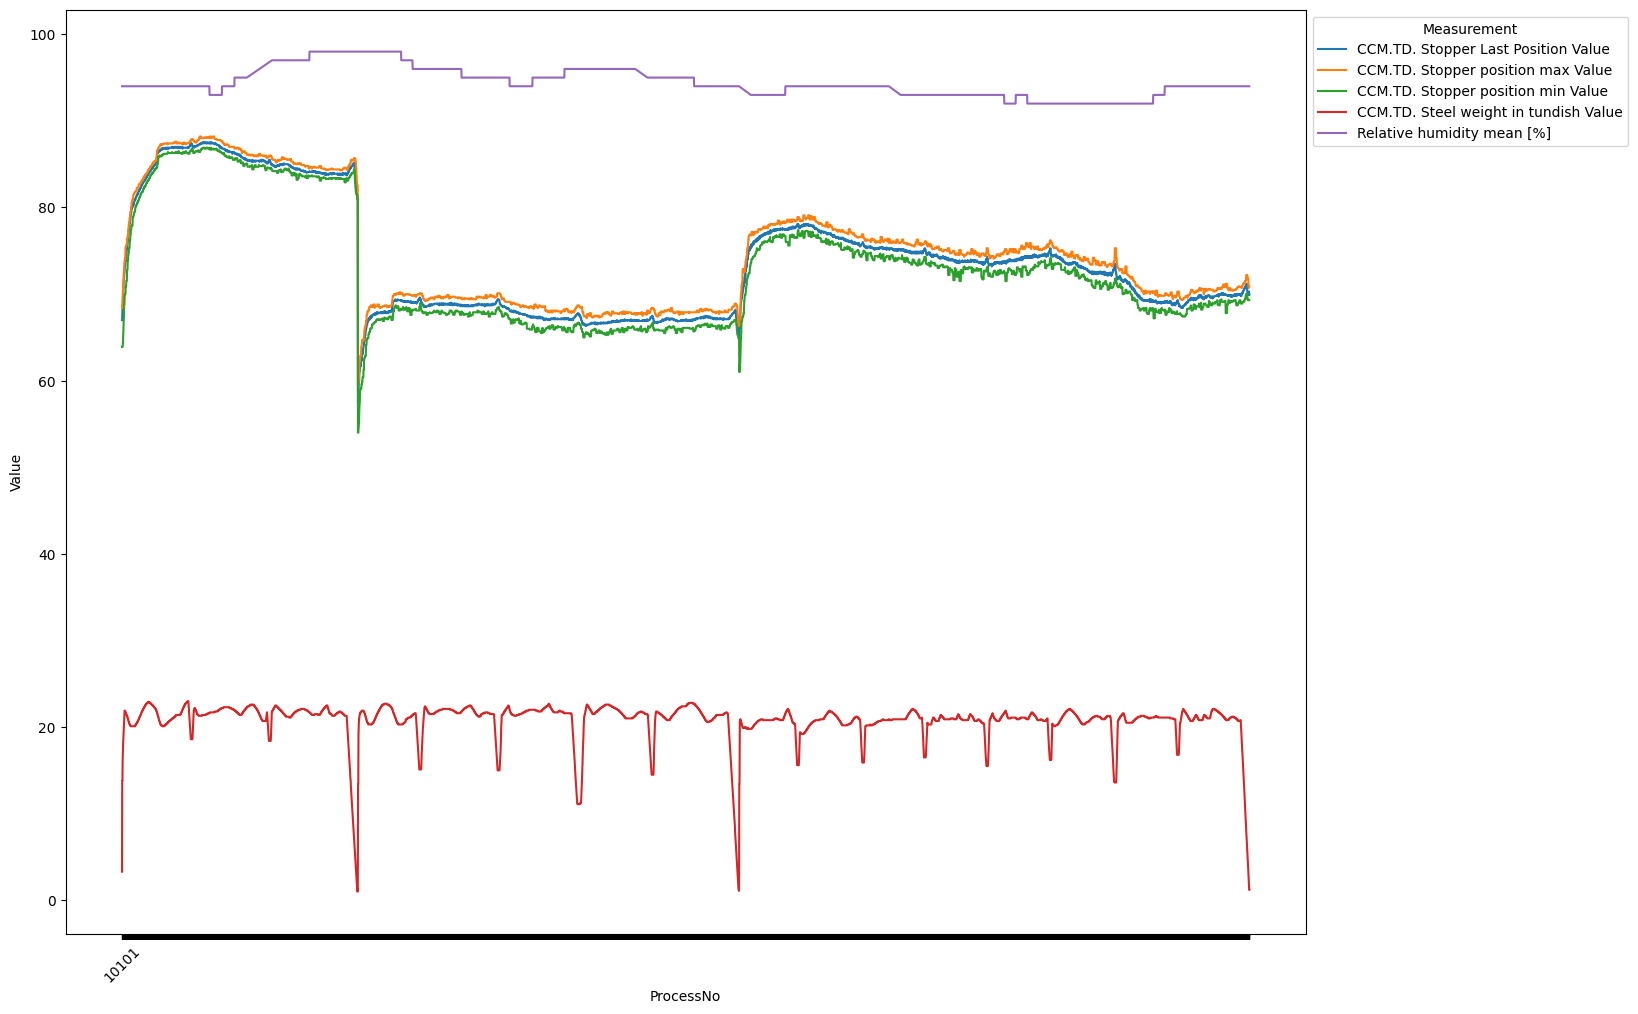

In [83]:
plt.figure(figsize=(16, 12))
plot = sns.lineplot(data=df_melt_middle, x="ProcessNo", y="Value", hue="Measurement", ci=None)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1,1))

# reduce the number of x-labels
n = len(df_single) / 20
[l.set_visible(False) for (i, l) in enumerate(plot.xaxis.get_ticklabels()) if i % n != 0]

# NOTE! using ; in the following line will suppress the Jupyter Notebook 
# default printing behavior of the last line (no idea why this happens!)
plt.xticks(rotation=45);

# you can now use the x-axis rought estimation of the Process No
# if you wish to look the data in more detail of certain trends
# Process No -> example: 20141 => Heat no 2 => slab no 02 => segment no 41

In [84]:
# plot = sns.lineplot(data=df_melt_low, x="ProcessNo", y="Value", hue="Measurement", ci=None)
# sns.move_legend(plot, "upper left", bbox_to_anchor=(1,1))

# reduce the number of x-labels
# n = len(df_single) / 20
# [l.set_visible(False) for (i, l) in enumerate(plot.xaxis.get_ticklabels()) if i % n != 0]

# NOTE! using ; in the following line will suppress the Jupyter Notebook 
# default printing behavior of the last line (no idea why this happens!)
# plt.xticks(rotation=45);

# you can now use the x-axis rought estimation of the Process No
# if you wish to look the data in more detail of certain trends
# Process No -> example: 20141 => Heat no 2 => slab no 02 => segment no 41

In [85]:
# plot = sns.lineplot(data=df_melt_low2, x="ProcessNo", y="Value", hue="Measurement", ci=None)
# sns.move_legend(plot, "upper left", bbox_to_anchor=(1,1))


# reduce the number of x-labels
# n = len(df_single) / 20
# [l.set_visible(False) for (i, l) in enumerate(plot.xaxis.get_ticklabels()) if i % n != 0]

# NOTE! using ; in the following line will suppress the Jupyter Notebook 
# default printing behavior of the last line (no idea why this happens!)
# plt.xticks(rotation=45);

# you can now use the x-axis rought estimation of the Process No
# if you wish to look the data in more detail of certain trends
# Process No -> example: 20141 => Heat no 2 => slab no 02 => segment no 41

In [86]:
# compare Casts 100, 125, 171 
# different stopper are in use, how does this correlate with the 
# phenomena we see in the data!
df_10_humid[['Grade', 'CCM.TD. Stopper Last Position Value' ]].phik_matrix()

interval columns not set, guessing: ['CCM.TD. Stopper Last Position Value']


,Grade,CCM.TD. Stopper Last Position Value
Grade,1.000000,0.781899
CCM.TD. Stopper Last Position Value,0.781899,1.000000


In [87]:
df_80_humid[['Grade', 'CCM.TD. Stopper Last Position Value' ]].phik_matrix()

interval columns not set, guessing: ['CCM.TD. Stopper Last Position Value']


,Grade,CCM.TD. Stopper Last Position Value
Grade,1.000000,0.474044
CCM.TD. Stopper Last Position Value,0.474044,1.000000


In [88]:
df_single.columns

Index(['index', 'End time', 'Weight', 'Length', 'Thickness', 'Width', 'Grade',
       'Quality Status', 'Seg No', 'CCM.TD. Heat counter Value',
       'CCM.TD. Temperature liquidus Value',
       'CCM.TD. Temperature liquidus Dynaphase Value',
       'CCM.TD. Slag powder Value', 'CCM.TD. Stopper Type Value',
       'CCM.TD. Steel weight in tundish Value', 'CCM.TD. Tundish inflow Value',
       'CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Stopper pos chg max segment Value',
       'CCM.TD. Stopper position chg 10 s Value',
       'CCM.TD. Stopper position slab chg Value', 'CCM.TD. Superheat Value',
       'CCM.TD. Temperature tundish Value', 'CCM.SEN. SEN Type Value',
       'CCM.SEN. Immersion depth Value', 'CCM.MD. Level average Value',
       'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
       'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Val

In [89]:
# stopper type, steel grade, SEN type ... do these correlate/associate in any way?
# does variation differ between stopper types? (e.g. is one of the types more prone
# to clogging in the long run etc.)

In [90]:
df['CCM.TD. Stopper position max Value'].min()

np.float64(48.4)